In [52]:
from typing import OrderedDict 
import torch
from torch._C import device
import torch.nn as nn
from torch.nn.modules.loss import CrossEntropyLoss
from torch.serialization import load
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import optim
import numpy as np
from IPython.display import HTML
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [53]:
# Root directory for dataset
dataroot = "data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 255

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [54]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(255),
                                transforms.ToTensor()
                                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

In [55]:
dataset = datasets.ImageFolder('cropped', transform=transform)

In [56]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [57]:
images, labels = next(iter(dataloader))

In [58]:
images[0].shape

torch.Size([3, 255, 255])

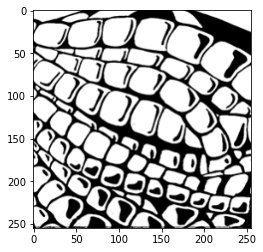

In [59]:
plt.imshow(images[50].permute(1, 2, 0))

In [60]:
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

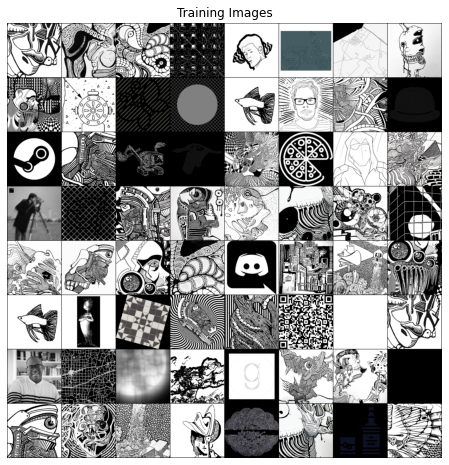

In [61]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [62]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [63]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [64]:
netG = Generator(ngpu).to(device)

In [65]:
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [69]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=4, stride=2, padding=1, bias=False)
    self.batch_norm1 = nn.BatchNorm2d(num_features=ndf)
    self.act1 = nn.LeakyReLU(negative_slope=0.2)
    
    self.conv2 = nn.Conv2d(in_channels=ndf, out_channels=ndf * 2, kernel_size=4, stride=2, padding=1, bias=False)
    self.batch_norm2 = nn.BatchNorm2d(num_features=ndf * 2)
    self.act2 = nn.LeakyReLU(negative_slope=0.2)
    
    self.conv3 = nn.Conv2d(in_channels=ndf * 2, out_channels=ndf * 4, kernel_size=4, stride=2, padding=1, bias=False)
    self.act3 = nn.LeakyReLU(negative_slope=0.2)
    self.batch_norm3 = nn.BatchNorm2d(num_features=ndf * 8)

    self.conv4 = nn.Conv2d(in_channels=ndf * 4, out_channels=ndf * 8, kernel_size=4, stride=2, padding=1, bias=False)
    self.act4 = nn.LeakyReLU(negative_slope=0.2)
    self.batch_norm4 = nn.BatchNorm2d(num_features=ndf * 8)

    self.conv5 = nn.Conv2d(in_channels=ndf * 8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False)
    self.act5 = nn.ReLU()


    self.fc1 = nn.Linear(8 * 4 * 4, 64)
    self.act4 = nn.ReLU()
    self.fc2 = nn.Linear(64, 2)

  def to(self, *args, **kwargs):
    return super().to(*args, **kwargs)

In [73]:
class Discriminator(Net):
    def __init__(self):
        super().__init__()
        self.L1 = nn.Linear(144, 1)

        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(in_channels=ndf, out_channels=ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=ndf * 2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(in_channels=ndf * 2, out_channels=ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=ndf * 4),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(in_channels=ndf * 4, out_channels=ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=ndf * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(in_channels=ndf * 8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.ReLU()
        )

    def forward(self, input):
        out = self.act1(self.conv1(input))
        out = self.act2(self.batch_norm2(self.conv2(out)))
        out = self.act3(self.batch_norm3(self.conv3(out)))
        out = self.act4(self.batch_norm4(self.conv4(out)))
        out = self.act5(self.conv5(out))
        out = out.view(-1, 144)
        out = self.L1(out)
        return out

In [74]:
netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): LeakyReLU(negative_slope=0.2)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): LeakyReLU(negative_slope=0.2)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (act3): LeakyReLU(negative_slope=0.2)
  (batch_norm3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (act4): ReLU()
  (batch_norm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (act5): ReLU()
  (fc1)

In [75]:
criterion = nn.BCEWithLogitsLoss()
fixed_noise = torch.randn(255, nz, 1, 1, device=device)
real_label = 1.
fake_label = 0.
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [76]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device).unsqueeze(1)
                # Forward pass real batch through D
        output = netD(real_cpu)
        
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


RuntimeError: running_mean should contain 256 elements not 512

In [33]:
output = netD(real_cpu)

In [ ]:
        # Forward pass real batch through D
        output = netD(real_cpu)
        
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1